In [3]:
import gmsh
import numpy as np
import meshio
import matplotlib.pyplot as plt
import importlib
import functions as func

importlib.reload(func)

import contextlib
import os
from urllib.request import urlretrieve

from scipy.integrate import solve_ivp
from sympy import *


#### Breakwater parameters

In [4]:
# Domain parameters
seaside = 10  # Length of the domain in x-direction
roof = 13  # Length of the domain in y-direction (roof of the crownwall)
top = 10 # top of the caisson
wall = 8 # location of the left side of the crownwall
tip = 1 # tip of the crownwall


#### Mesh definition

In [5]:
gmsh.initialize()
gmsh.model.add("Breakwater")

# Tag offset
tag = 1


# Mesh size
lc_big = 3
lc_small = 3

p_center = gmsh.model.geo.addPoint(seaside+tip, roof-2*tip, 0, lc_small, tag); tag += 1

# Outer rectangle points
p1 = gmsh.model.geo.addPoint(0, 0, 0, lc_big, tag); tag += 1
p2 = gmsh.model.geo.addPoint(0, top, 0, lc_big, tag); tag += 1
p3 = gmsh.model.geo.addPoint(wall, top, 0, lc_small, tag); tag += 1
p4 = gmsh.model.geo.addPoint(wall, roof, 0, lc_small, tag); tag += 1
p5 = gmsh.model.geo.addPoint(seaside+tip, roof, 0, lc_small, tag); tag += 1
p6 = gmsh.model.geo.addPoint(seaside+tip, roof-tip, 0, lc_small, tag); tag += 1
p7 = gmsh.model.geo.addPoint(seaside, roof-2*tip, 0, lc_small, tag); tag += 1
p8 = gmsh.model.geo.addPoint(seaside, 0, 0, lc_big, tag); tag += 1

# Outer rectangle lines
l_a = gmsh.model.geo.addLine(p1, p2)
l_b = gmsh.model.geo.addLine(p2, p3)
l_c = gmsh.model.geo.addLine(p3, p4)
l_d = gmsh.model.geo.addLine(p4, p5)
l_e = gmsh.model.geo.addLine(p5, p6)
l_f = gmsh.model.geo.addCircleArc(p6, p_center, p7)
l_g = gmsh.model.geo.addLine(p7, p8)
l_h = gmsh.model.geo.addLine(p8, p1)


# Define surface with a hole
outer_loop = gmsh.model.geo.addCurveLoop([l_a, l_b, l_c, l_d, l_e, l_f, l_g, l_h])
surface = gmsh.model.geo.addPlaneSurface([outer_loop])

gmsh.model.geo.synchronize()

# # Define physical group for the interior domain
interior_tag = 3  # Assign a physical group ID
gmsh.model.addPhysicalGroup(2, [surface], interior_tag)  # 2 corresponds to surface dimension

sea_side_tag = 1  # Assign a physical group ID
gmsh.model.addPhysicalGroup(1, [l_f, l_g, l_e], sea_side_tag)  # 1 to the line segment

# # Define physical boundary for the left vertical side (l4)
bottom_side_tag = 2  # Assign a physical group ID
gmsh.model.addPhysicalGroup(1, [l_h], bottom_side_tag)  # 1 to the line segment

# Generate the mesh
# gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)
gmsh.write("Breakwater.msh")

#### Mesh plotting & boundary visualization

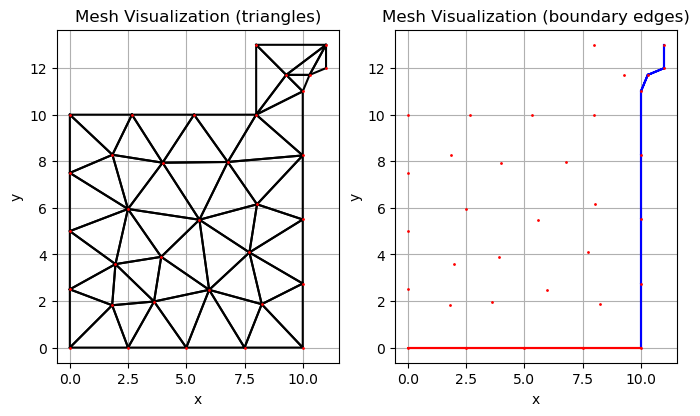

In [6]:
# Read mesh from file
mesh = meshio.read("Breakwater.msh")

# Extract node coordinates and triangle connectivity
points = mesh.points[:, :2]  # (x, y)
triangles = mesh.get_cells_type("triangle")
groups = mesh.get_cell_data("gmsh:physical", "line")
# edges = mesh.get_cells_type("line") # edges on the left boundary
# edges = mesh.cells_dict.get(2, [])  # edges on the left boundary
bottom_edges = mesh.get_cells_type("line")[groups == bottom_side_tag]
sea_edges = mesh.get_cells_type("line")[groups == sea_side_tag]

# Plot triangles
fig, ax = plt.subplots(1,2, figsize=(8, 8))
for tri in triangles:
    coords = points[tri]
    coords = np.vstack((coords, coords[0]))  # close the triangle
    ax[0].plot(coords[:, 0], coords[:, 1], 'k-')
ax[0].plot(points[:, 0], points[:, 1], 'ro', markersize=1)
ax[0].set_aspect('equal')
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Mesh Visualization (triangles)")
ax[0].grid(True)

# Plot edges
for edge in sea_edges:
    coords = points[edge]
    coords = np.vstack((coords, coords[0]))  # close the line
    ax[1].plot(coords[:, 0], coords[:, 1], 'blue', label = "ver")
for edge in bottom_edges:
    coords = points[edge]
    coords = np.vstack((coords, coords[0]))  # close the line
    ax[1].plot(coords[:, 0], coords[:, 1], 'red', label = "hor")
ax[1].plot(points[:, 0], points[:, 1], 'ro', markersize=1)
ax[1].set_aspect('equal')
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Mesh Visualization (boundary edges)")
ax[1].grid(True)
plt.show()


#### Testing gauspoints

In [7]:
# #Testing Triangle

# def f(x, y):
#     return x * y

# gps1, weights1 = GaussPoints(1)
# int1 = sum(f(gps1[i, 0], gps1[i, 1]) * weights1[i] for i in range(len(weights1)))
# print("Integral of f(x,y) over the triangle", int1, "should be:", 1/24)

# gps3, weights3 = GaussPoints(3)
# int3 = sum(f(gps3[i, 0], gps3[i, 1]) * weights3[i] for i in range(len(weights3)))
# print("Integral of f(x,y) over the triangle", int3, "should be:", 1/24)


#### Parameters and boundary condtions

In [8]:
# Problem parameters
E = 36e9  # Young's modulus in Pa
nu = 0.3  # Poisson's ratio
k_bottom = 5
density = 2500  # Density in kg/m^3
# body_force = np.array([0, -9.81 * density])  # Body force (gravity)
body_force = np.array([0, 0])  # Body force (gravity)
C = func.elasticity_tensor(E, nu)
Force = 1

# Assemble the global stiffness matrix, mass matrix, and force vector
K, M, f = func.assemble(mesh, triangles, points, C, density, body_force)

# Find the nodes on the foundation (bottom) boundary
bottom_Bnodes = np.where(np.isin(points[:, 1], points[bottom_edges[:, 1], 0]))[0]
bottom_dofs = np.array([[2*n, 2*n+1] for n in bottom_Bnodes]).flatten()

# Find the nodes on the seaside boundary
sea_Bnodes = np.where(np.isin(points[:, 0], points[sea_edges[:, 0], 0]))[0]
sea_Bnodes = [int(x) for x in sea_Bnodes if x not in bottom_Bnodes] # exlcude bottom node(s) from seaside nodes
sea_dofs = np.array([[2*n, 2*n+1] for n in sea_Bnodes]).flatten()

# Apply the stiffness, mass
for dof in bottom_dofs:
    K[dof, :] = 0  # Set the row to zero
    K[dof, dof] += k_bottom
    M[dof, :] = 0  # Set the row to zero
    M[dof, dof] = 1  # Set the diagonal to 1
    f[dof] = 0  # Set the force vector to


for dof in sea_dofs:
    K[dof, :] = 0  # Set the row to zero
    K[dof, dof] = 1  # Set the diagonal to 1
    M[dof, :] = 0  # Set the row to zero
    M[dof, dof] = 1  # Set the diagonal to 1
    f[dof] = -1e-3  # Set the force vector to



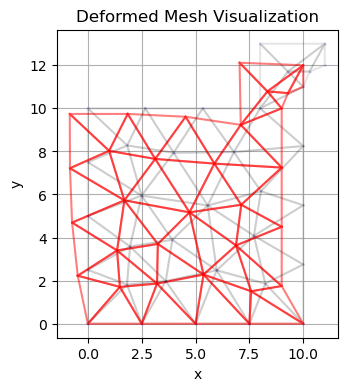

In [9]:
# Solve the system of equations
u = np.linalg.solve(K, f)

# Reshape the solution vector into a 2D array for visualization and magnify by 1e3
u_reshaped = u.reshape(-1, 2) * 1e3


# Plot the deformed mesh
plt.figure(figsize=(8, 4))
for tri in triangles:
    coords = points[tri]
    coords_displaced = coords + u_reshaped[tri]
    coords = np.vstack((coords, coords[0]))  # close the triangle
    coords_displaced = np.vstack((coords_displaced, coords_displaced[0]))  # close the triangle
    plt.plot(coords[:, 0], coords[:, 1], 'k-', alpha=0.1)
    plt.plot(coords_displaced[:,0],coords_displaced[:,1], 'r-', alpha=0.5)
plt.plot(points[:, 0], points[:, 1], 'bo', markersize=1, alpha =0.1)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Deformed Mesh Visualization")
plt.grid(True)
plt.show()

In [24]:
def goda_originial(beta, labda1, labda2, Hmax, l, rho, g, eta, hc, k):
    """
    Calculate the Goda pressure distribution based on the original formula.
    beta = angle of the wave direction
    labda1 = wave reflection coefficient for the first wave
    labda2 = wave reflection coefficient for the second wave
    Hmax = wave height
    l = length of the caisson
    L = wave length
    rho = density of the water
    eta = surface elevation
    """
    beta = 0
    h_b = h
    h_ = h

    alpha1 = 0.6 + 0.5 * ((2 * k * h) / np.sinh(2 * k * h)) ** 2
    alpha2 = min(((h_b - d) / (3* h_b)) * (Hmax / d)**2, (2*d) / Hmax)
    alpha3 = 1 - (h_ / h) * (1 - (1 / np.cosh(k * h)))
   
    p1 = 1/2 * (np.cos(beta) + 1) * (alpha1 * labda1 + alpha2 * labda2 *(np.cos(beta)) ** 2) * rho * g * Hmax
    p3 = alpha3 * p1
    return [p1, p3]

def array_Goda(l, h1, h2, eta, goda, plot=False):
    """
    Create an array of pressure values based on the Goda formula.
    l: total height of caisson [m]
    h1: SWL                         [m]
    h2: curvature height            [m]  
    """
    # define parameters
    p1 = goda[0]
    # p2 = goda[1]
    p3 = goda[1]
    d = eta + h1

    z = np.linspace(0, l, 1000) # z coordinate from bottom to top of the caisson

    # define the correction factors
    p3til = 5848 * H * l / (L ** 2) + 9.75
    p2til = 0.45 * p3til
    p1til = 0

    print("h1", h1, "h2", h2, "d", d)
    print("p1", p1, "p2", p2, "p3", p3)
    print("p1til", p1til, "p2til", p2til, "p3til", p3til)
    # Define the pressure distribution 
    q_goda = np.zeros(1000)

    Pv = np.zeros(len(z))  # Initialize pressure array
    Pr = np.zeros(len(z))  # Initialize corrected pressure array
    ptil = np.zeros(len(z))  # Initialize pressure correction array

    if d > h2:
        p4 = p1 * (h2 - h1) / (eta)
        print("d > h2")
        print("p4", p4)
        Pv[np.where(z < h1)] = np.linspace(p3, p1, np.sum(z < h1))  # linear interpolation from P1 to P2
        Pv[np.where(z >= h1)] = np.linspace(p1, p4, np.sum(z >= h1))  # linear interpolation from P2 to P3

        ptil[np.where(z < h1)] = 1+p1til
        ptil[np.where((z >= h1) & (z < h2))] = np.linspace(1+p1til, 1+p2til, np.sum((z >= h1) & (z < h2)))
        ptil[np.where(z >= h2)] = np.linspace(1+p2til, 1+p3til, np.sum(z >= h2))

        Pr = Pv * ptil

        if plot == True:
            plt.plot(ptil, z, label='Pressure Correction Factor')
            plt.ylabel('Height (m)')
            plt.xlabel('Pressure Correction Factor')
            plt.title('Pressure Correction Factor along the Caisson')
            plt.grid(True)
            plt.show()

            plt.plot(Pr, z, label='Corrected Goda Pressure Distribution')
            plt.ylabel('Height (m)')
            plt.xlabel('Pressure (Pa)')
            plt.title('Corrected Pressure Distribution along the Caisson')
            plt.grid(True)
            plt.legend()

    if d < h2:
        print("d < h2")
        Pv[np.where(z < h1)] = np.linspace(p3, p1, np.sum(z < h1))
        Pv[np.where((z >= h1) & (z < d))] = np.linspace(p1, 0, len(Pv[np.where((z >= h1) & (z < d))]))
        print("Pv", np.linspace(p1, 0, len(np.where((z >= h1) & (z < d)))))
        Pr = Pv.copy()  # No correction for this case

    if plot == True:
        plt.plot(Pv, z, label='Goda Pressure Distribution')
        plt.ylabel('Height (m)')
        plt.xlabel('Pressure (Pa)')
        plt.title('Pressure Distribution along the Caisson')
        plt.grid(True)
        plt.legend()

    # Correct the pressure values based on the correction factors

    return Pr






Testing Goda

h1 10 h2 12.5 d 15
p1 48265.20030897387 p2 3 p3 180.26436637928666
p1til 0 p2til 308.4835 p3til 685.5188888888889
d > h2
p4 24132.600154486936


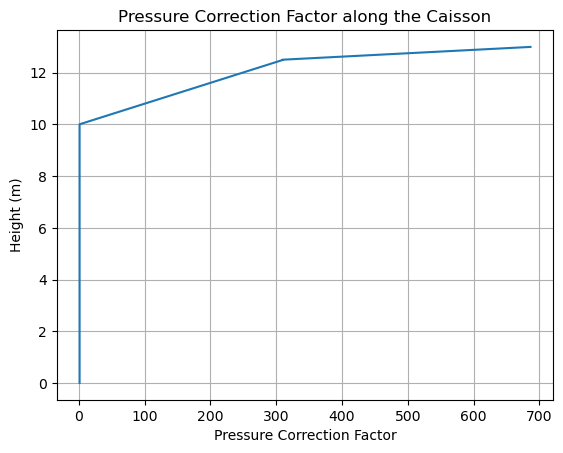

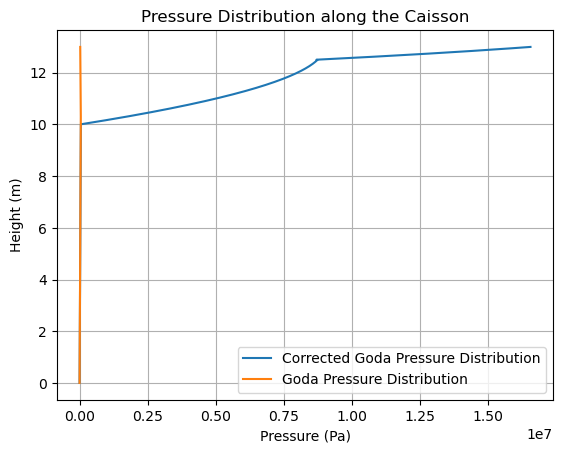

In [25]:
# examples of input values
h = 10
beta = 2
k = 2 * np.pi / 10  # wave number, assuming a wavelength of 10 m

H = 2
labda1 = 4
labda2 = 2
l = 13 # m
L = 15 # m
rho = 1025 # density of salt water
g = 9.81 #m/s^2
eta = 5 #surface elevation [m] (time dependent)
hc = 0.5 # [m] needs to be smaller than eta, otherwise negative P2

d = 10 
h1 = h
h2 = 12.5

goda = goda_originial(beta, labda1, labda2, H, l, rho, g, eta, hc, k)
Pv = array_Goda(l, h1, h2, eta, goda, plot=True)
# alpha1 = 0.1 * 1/2 * (2 * k * h / (np.sinh(2 * k * h))) ** 2
# #For shallow water: alpha1 = 0, for deep water: alpha = 0.05

# alpha2 = min((hb - d) / (3 * hb) * (Hmax /d) **2, 2 * d / Hmax)


# alpha3 = 1 - h_ / h * (1 - 1/(np.cosh(k * h)))

In [ ]:
A = goda(beta, alpha1, alpha2, alpha3, labda1, labda2, H, l, L, rho, g, eta, hc)
print(A)

array = array_Goda(d, h1, h2, A)
print(array)

x = np.linspace(0, len(array), len(array))
plt.plot(x, array)

TypeError: 'list' object is not callable

In [ ]:
dt = 0.1 # timestep
T = 10 # total time
time_steps = np.arange(1, T, dt)

# Force applied to the system
f[dof] = -1e-3

# Initial conditions
u = np.zeros_like(f)        # displacement
v = np.zeros_like(f)        # velocity
a = np.zeros_like(f)        # acceleration


# Damping is set to 0
C_damp = np.zeros_like(K)

In [ ]:
u = []
for t in time_steps:
    f = f * np.sin(2 * np.pi * t)
    u_new = np.linalg.solve(K, f)
    u_new_reshaped = u_new.reshape(-1, 2) * 1e3
    print(u_new_reshaped)

    for tri in triangles:
        coords = points[tri]
        coords_displaced = coords + u_new_reshaped[tri]
        coords = np.vstack((coords, coords[0]))  # close the triangle
        coords_displaced = np.vstack((coords_displaced, coords_displaced[0]))  # close the triangle

[[ 8.72243349e-29  2.14138272e-29]
 [ 2.05530268e-16  6.38384474e-17]
 [ 2.20574647e-16  1.87733633e-16]
 [ 2.33970336e-16  2.16100360e-16]
 [ 2.44929360e-16  2.44929360e-16]
 [ 2.44929360e-16  2.44929360e-16]
 [ 2.44929360e-16  2.44929360e-16]
 [-1.63185879e-25 -2.37138436e-25]
 [ 1.15171550e-16  6.61133395e-17]
 [ 1.79344917e-16  7.44220725e-17]
 [ 2.03315161e-16  6.89213561e-17]
 [ 1.99871925e-16  6.36554757e-17]
 [ 1.94586564e-16  9.57186672e-17]
 [ 2.44929360e-16  2.44929360e-16]
 [ 2.44929360e-16  2.44929360e-16]
 [ 2.44929360e-16  2.44929360e-16]
 [ 2.44929360e-16  2.44929360e-16]
 [-6.17755033e-27 -5.90702374e-27]
 [ 7.45269525e-27  6.00356204e-28]
 [ 1.37549175e-28  4.69224509e-29]
 [ 2.03868608e-16  1.10194487e-16]
 [ 2.09688556e-16  7.05555796e-17]
 [ 1.47373203e-16  4.42821097e-17]
 [ 2.22303107e-16  1.31096337e-16]
 [ 2.06433699e-16  7.80604496e-17]
 [ 1.49886051e-16  4.84021954e-17]
 [ 1.95837582e-16  5.40030928e-17]
 [ 9.90715399e-17  2.82650220e-17]
 [ 2.33848962e-16  2

In [ ]:
def find_dz(z_coords):    
    dz_list = np.zeros(len(z_coords))
    z_coords_temp = points[sea_dofs][:, 1]
    while z_coords_temp.shape[0] > 0:
        z_coord = z_coords_temp.min()
        z_coords_temp = np.delete(z_coords_temp, np.where(z_coords_temp == z_coord)[0][0])
        if z_coords_temp.shape[0] > 0:
            z_coord_i = z_coords_temp.min()
        dz = z_coord_i - z_coord
        dz_list[np.where(z_coords == z_coord)] = dz
    return dz_list


z_coord [ 2.5         5.          7.5        10.         10.         11.70710678
  5.95000869  1.97791063 11.7082267   6.15115127  1.81739816  3.89601364
  8.27764429  1.86298147]
z = 2.499999999995367, i = [0]
z = 4.999999999992411, i = [1]
z = 7.499999999996209, i = [2]
z = 10.0, i = [3 4]
z = 10.0, i = [3 4]
z = 11.70710677887874, i = [5]
z = 5.950008692756057, i = [6]
z = 1.977910630432418, i = [7]
z = 11.70822670373663, i = [8]
z = 6.151151271184427, i = [9]
z = 1.817398161387068, i = [10]
z = 3.896013637321923, i = [11]
z = 8.277644285184676, i = [12]
z = 1.862981474403313, i = [13]


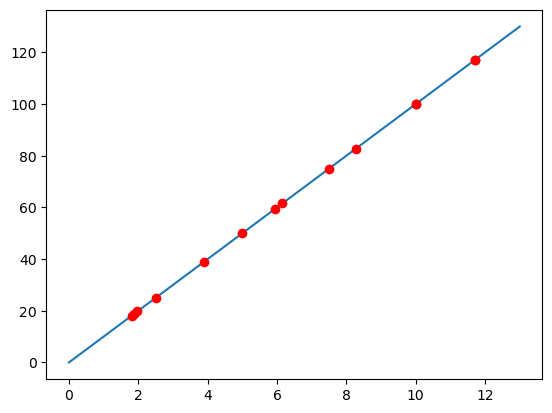

In [ ]:
n_fp = 100
z = np.linspace(0, roof, n_fp)
q = z * 10
plt.plot(z, q, label='Force over length')
z_coords = points[sea_dofs][:, 1]
q_interp = np.interp(z_coords, z, q)
plt.plot(z_coords, q_interp, 'ro', label='Interpolated Force')
print("z_coord", z_coords)
# print(sea_dofs)
dz = z_coords[1] - z_coords[0]

for dof in sea_dofs:
    z_coord = points[dof, 1]
    i = np.where(z_coords == z_coord)[0]
    print(f"z = {z_coord}, i = {i}")
    q_comp = q_interp[np.where(z_coords == z_coord)[0]][0]
    F_comp = q_comp * dz
    f[dof] = q_comp

def interp_force(z_coords, q, L):
    n = len(q)
    z = np.linspace(0, L, n)
    q_interp = np.interp(z_coords, z, q)